<a href="https://colab.research.google.com/github/alexis-castellanos/umsi-siads-696/blob/main/SIADS696_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# --- Setup and Environment ---

In [14]:
!pip install ucimlrepo

In [15]:
# Income Prediction - UCI Adult Dataset Exploration
# Author: Castellanos, Alexis
# Date: May, 14, 2025

"""
This notebook explores the UCI Adult Income Dataset with the goal of predicting
whether income exceeds $50K/yr based on census data.
"""

# --- Setup and Environment ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set plot style and parameters
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# Setting a random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


# --- Data Loading ---

In [16]:
# --- Data Loading ---
# Function to load data
def load_dataset(url, sample_size=None):
    """
    Load the UCI Adult dataset from URL

    Parameters:
    -----------
    url : str
        URL to the dataset
    sample_size : int, optional
        Number of samples to load, if None load all

    Returns:
    --------
    pd.DataFrame
        Loaded dataset
    """
    # Column names according to the UCI repository
    column_names = [
        'age', 'workclass', 'fnlwgt', 'education', 'education_num',
        'marital_status', 'occupation', 'relationship', 'race', 'sex',
        'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income'
    ]

    print(f"Attempting to load data from: {url}")
    print(f"Using column names: {column_names}")

    # Attempt several methods of loading the data
    methods = [
        {"sep": ", ", "engine": "python", "header": None, "na_values": " ?"},
        {"sep": ",", "header": None, "na_values": "?"},
        {"sep": ",\s+", "engine": "python", "header": None, "na_values": "?"},
        {"sep": "\s+", "engine": "python", "header": None, "na_values": "?"},
        {"sep": None, "engine": "python", "header": None, "delim_whitespace": True, "na_values": "?"}
    ]

    data = None
    error_msgs = []

    for i, method_params in enumerate(methods):
        try:
            print(f"\nMethod {i+1}: Trying with parameters: {method_params}")
            data = pd.read_csv(url, names=column_names, **method_params)

            # Verify the data looks reasonable
            print(f"Data shape: {data.shape}")
            print(f"First 3 rows:\n{data.head(3)}")

            # Check if income column exists and has values
            if 'income' in data.columns and not data['income'].isnull().all():
                print(f"Method {i+1} successful! Loaded data with shape: {data.shape}")
                break
            else:
                print(f"Method {i+1} failed: Missing or invalid income column")
                data = None
        except Exception as e:
            error_msg = f"Method {i+1} failed with error: {str(e)}"
            print(error_msg)
            error_msgs.append(error_msg)
            data = None

    if data is None or len(data) == 0:
        print(f"All methods failed to load data properly")
        for msg in error_msgs:
            print(f"  - {msg}")
        return None

    # Check class distribution
    print("\nClass distribution in loaded data:")
    income_counts = data['income'].value_counts()
    print(income_counts)

    # Check for and sample if needed
    if sample_size is not None and sample_size < len(data):
        # Split by class
        try:
            # Identify the income classes - check for both formats
            gt_50k_values = [x for x in income_counts.index if '>50K' in str(x)]
            lte_50k_values = [x for x in income_counts.index if '<=50K' in str(x)]

            if not gt_50k_values or not lte_50k_values:
                print("Warning: Could not identify income classes properly")
                if sample_size < len(data):
                    # Random sample as fallback
                    data = data.sample(sample_size, random_state=RANDOM_STATE)
            else:
                # Take the first matching value for each class
                gt_50k_value = gt_50k_values[0]
                lte_50k_value = lte_50k_values[0]

                high_income = data[data['income'] == gt_50k_value]
                low_income = data[data['income'] == lte_50k_value]

                print(f"Found {len(high_income)} instances of '{gt_50k_value}' class")
                print(f"Found {len(low_income)} instances of '{lte_50k_value}' class")

                # Calculate sample sizes
                high_count = min(int(sample_size * 0.3), len(high_income))
                low_count = min(sample_size - high_count, len(low_income))

                print(f"Sampling {high_count} high income and {low_count} low income records")

                # Sample
                high_sample = high_income.sample(high_count, random_state=RANDOM_STATE) if high_count > 0 else pd.DataFrame(columns=data.columns)
                low_sample = low_income.sample(low_count, random_state=RANDOM_STATE) if low_count > 0 else pd.DataFrame(columns=data.columns)

                # Combine
                data = pd.concat([high_sample, low_sample])
                data = data.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

                print(f"Final sample shape: {data.shape}")
                print("Final class distribution:")
                print(data['income'].value_counts())
        except Exception as e:
            print(f"Error during sampling: {str(e)}")
            # Fallback to random sampling
            print("Falling back to random sampling")
            if sample_size < len(data):
                data = data.sample(sample_size, random_state=RANDOM_STATE)

    return data

# Try to load the dataset
train_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
df_train = load_dataset(train_url, sample_size=5000)

Attempting to load data from: https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Using column names: ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']

Method 1: Trying with parameters: {'sep': ', ', 'engine': 'python', 'header': None, 'na_values': ' ?'}
Data shape: (32561, 15)
First 3 rows:
   age         workclass  fnlwgt  education  education_num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   

       marital_status         occupation   relationship   race   sex  \
0       Never-married       Adm-clerical  Not-in-family  White  Male   
1  Married-civ-spouse    Exec-managerial        Husband  White  Male   
2            Divorced  Handlers-cleaners  Not-in-family  White  Ma

# --- Data Exploration ---

In [17]:
# --- Data Exploration ---
def explore_data(df):
    """
    Perform initial data exploration

    Parameters:
    -----------
    df : pd.DataFrame
        Dataset to explore
    """
    # Check if DataFrame is valid
    if df is None or len(df) == 0:
        print("Error: DataFrame is empty or None. Cannot explore data.")
        return

    # Display basic information
    print("\n=== Dataset Overview ===")
    print(f"Dataset shape: {df.shape}")
    print("\nFirst 5 rows:")
    try:
        display(df.head())
    except Exception as e:
        print("Error displaying first 5 rows:", str(e))
        print(df.head())

    # Check data types and missing values
    print("\n=== Data Types and Missing Values ===")
    try:
        missing_data = pd.DataFrame({
            'Data Type': df.dtypes,
            'Missing Values': df.isnull().sum(),
            'Missing Percentage': df.isnull().sum() / len(df) * 100
        })
        display(missing_data)
    except Exception as e:
        print("Error calculating missing values:", str(e))
        print("Data types:")
        print(df.dtypes)
        print("Missing values:")
        print(df.isnull().sum())

    # Summary statistics for numerical features
    print("\n=== Numerical Features Summary ===")
    try:
        display(df.describe())
    except Exception as e:
        print("Error generating numerical summary:", str(e))

    # Summary for categorical features
    print("\n=== Categorical Features Summary ===")
    try:
        cat_cols = df.select_dtypes(include=['object']).columns
        for col in cat_cols:
            print(f"\n{col} value counts:")
            display(df[col].value_counts().head())
    except Exception as e:
        print("Error generating categorical summary:", str(e))
        print("Categorical columns:", df.select_dtypes(include=['object']).columns.tolist())

    # Target distribution
    print("\n=== Target Distribution ===")
    try:
        if 'income' in df.columns:
            target_counts = df['income'].value_counts()
            print("Raw target counts:")
            print(target_counts)

            # Check if DataFrame has rows
            if len(df) > 0:
                # Find values that match '>50K' and '<=50K' patterns
                gt_50k_values = [x for x in target_counts.index if '>50K' in str(x)]
                lte_50k_values = [x for x in target_counts.index if '<=50K' in str(x)]

                if gt_50k_values:
                    gt_50k = gt_50k_values[0]
                    gt_50k_pct = target_counts.get(gt_50k, 0) / len(df) * 100
                    print(f"Percentage of income '{gt_50k}': {gt_50k_pct:.2f}%")
                else:
                    print("No >50K income values found")

                if lte_50k_values:
                    lte_50k = lte_50k_values[0]
                    lte_50k_pct = target_counts.get(lte_50k, 0) / len(df) * 100
                    print(f"Percentage of income '{lte_50k}': {lte_50k_pct:.2f}%")
                else:
                    print("No <=50K income values found")
            else:
                print("DataFrame is empty. Cannot calculate target distribution.")
        else:
            print("'income' column not found in the DataFrame")
            print("Available columns:", df.columns.tolist())
    except Exception as e:
        print("Error calculating target distribution:", str(e))
        import traceback
        traceback.print_exc()

# Run exploration
if df_train is not None:
    explore_data(df_train)


=== Dataset Overview ===
Dataset shape: (5000, 15)

First 5 rows:


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,19,?,182609,HS-grad,9,Never-married,?,Own-child,Black,Female,0,0,25,United-States,<=50K
1,51,Self-emp-not-inc,218311,Some-college,10,Divorced,Sales,Unmarried,White,Female,0,0,50,United-States,<=50K
2,22,Private,107882,Bachelors,13,Never-married,Exec-managerial,Own-child,White,Female,0,0,35,United-States,<=50K
3,38,Private,256864,HS-grad,9,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,50,United-States,>50K
4,35,Private,38948,Some-college,10,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,>50K



=== Data Types and Missing Values ===


,Data Type,Missing Values,Missing Percentage
age,int64,0,0.0
workclass,object,0,0.0
fnlwgt,int64,0,0.0
education,object,0,0.0
education_num,int64,0,0.0
marital_status,object,0,0.0
occupation,object,0,0.0
relationship,object,0,0.0
race,object,0,0.0
sex,object,0,0.0



=== Numerical Features Summary ===


,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,38.999600,189244.219400,10.182200,1361.050400,96.562800,40.888200
std,13.409324,102243.193951,2.644391,8348.784269,421.916984,12.638958
min,17.000000,14878.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,118173.000000,9.000000,0.000000,0.000000,40.000000
50%,38.000000,178312.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,236631.750000,13.000000,0.000000,0.000000,45.000000
max,90.000000,809585.000000,16.000000,99999.000000,3900.000000,99.000000



=== Categorical Features Summary ===

workclass value counts:


,count
workclass,
Private,3477
Self-emp-not-inc,377
Local-gov,321
?,276
State-gov,203



education value counts:


,count
education,
HS-grad,1538
Some-college,1102
Bachelors,867
Masters,324
11th,184



marital_status value counts:


,count
marital_status,
Married-civ-spouse,2468
Never-married,1558
Divorced,628
Separated,146
Widowed,135



occupation value counts:


,count
occupation,
Prof-specialty,698
Craft-repair,636
Exec-managerial,624
Sales,583
Adm-clerical,528



relationship value counts:


,count
relationship,
Husband,2199
Not-in-family,1204
Own-child,737
Unmarried,473
Wife,234



race value counts:


,count
race,
White,4303
Black,459
Asian-Pac-Islander,155
Other,43
Amer-Indian-Eskimo,40



sex value counts:


,count
sex,
Male,3485
Female,1515



native_country value counts:


,count
native_country,
United-States,4475
Mexico,104
?,97
Germany,27
Philippines,22



income value counts:


,count
income,
<=50K,3500
>50K,1500



=== Target Distribution ===
Raw target counts:
income
<=50K    3500
>50K     1500
Name: count, dtype: int64
Percentage of income '>50K': 30.00%
Percentage of income '<=50K': 70.00%


# --- Data Visualization ---

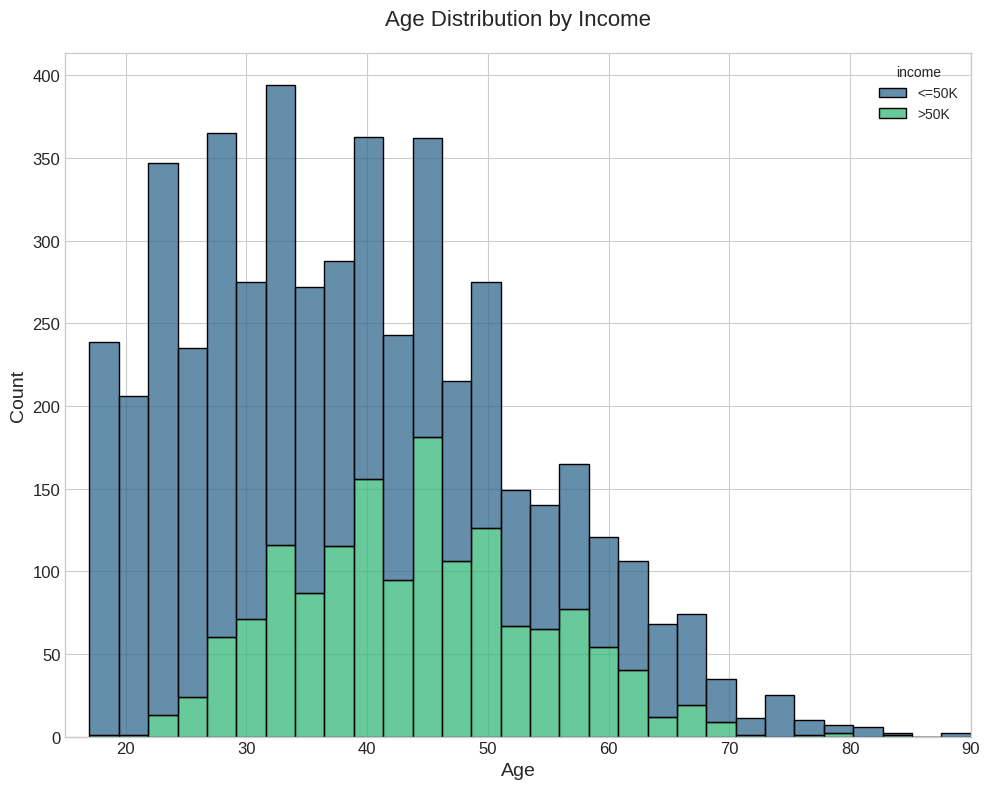

Income category columns in education crosstab:
['<=50K', '>50K']


<Figure size 1200x1000 with 0 Axes>

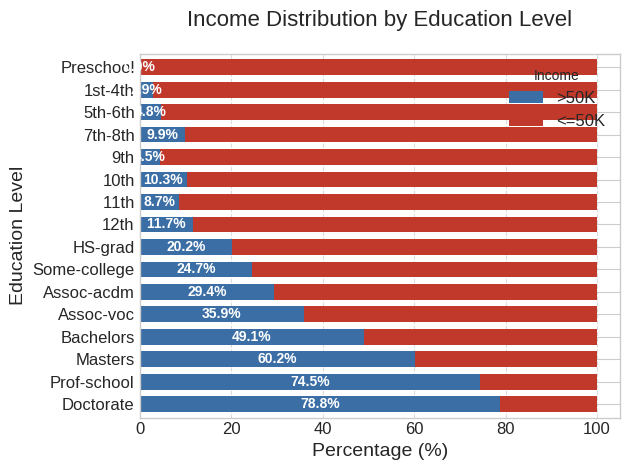

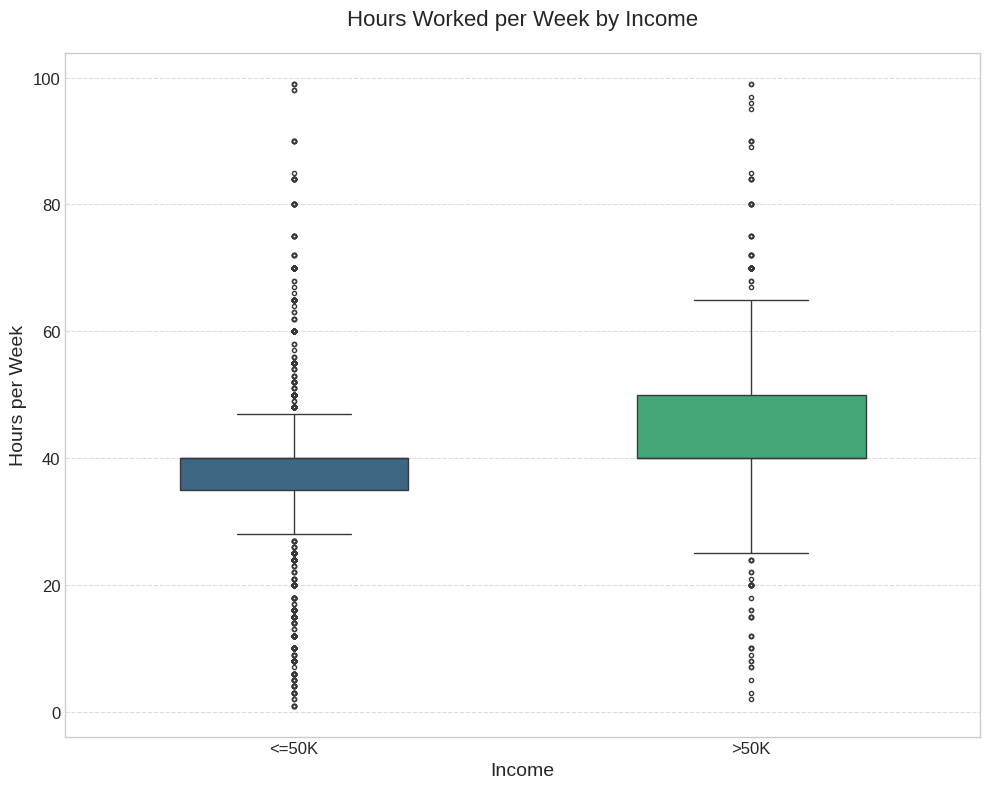

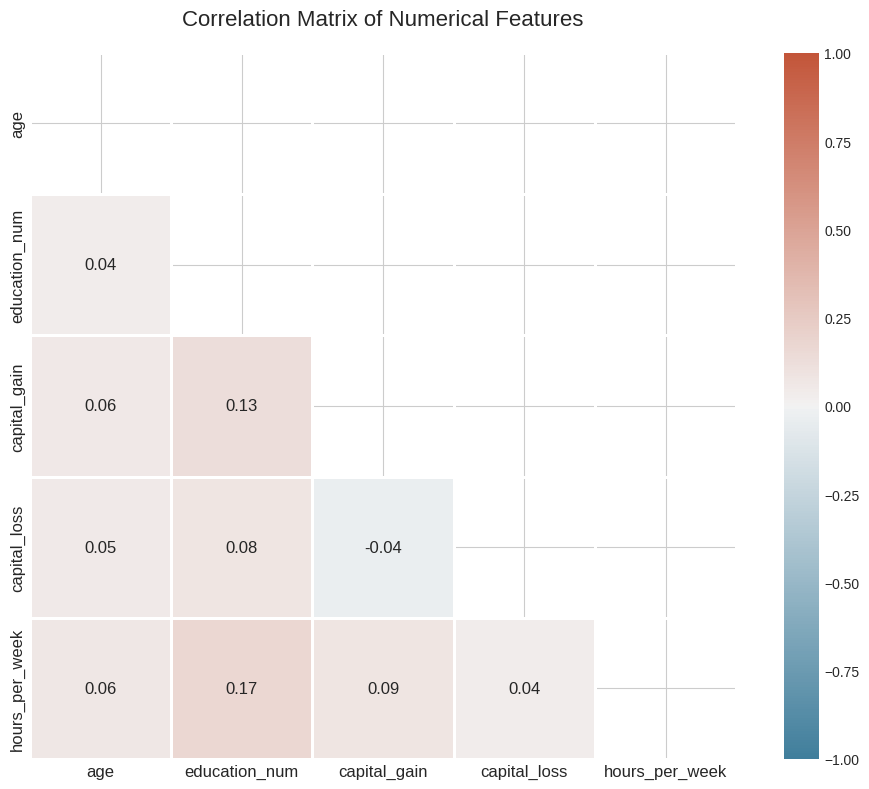

<Figure size 1400x700 with 0 Axes>

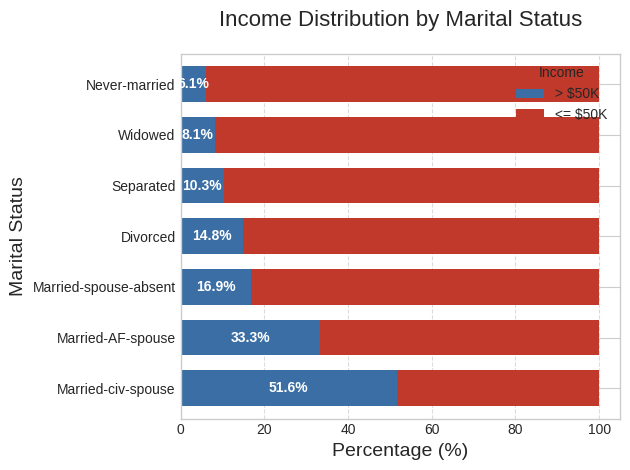

Income category columns in occupation crosstab:
['<=50K', '>50K']


<Figure size 1400x1000 with 0 Axes>

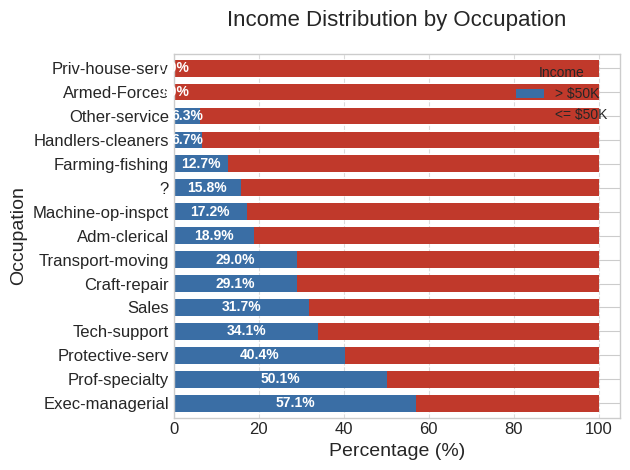

In [18]:
# --- Data Visualization ---
def create_visualizations(df):
    """
    Create visualizations for EDA - one by one to avoid overlapping

    Parameters:
    -----------
    df : pd.DataFrame
        Dataset to visualize
    """
    # Clear any existing plots to avoid interference
    plt.close('all')

    # 1. Age histogram by income - SEPARATE FIGURE
    plt.figure(figsize=(10, 8), dpi=100)
    # Get income categories to use for legend and consistent colors
    income_categories = df['income'].unique().tolist()
    sns.histplot(data=df, x='age', hue='income', bins=30, multiple='stack',
                 palette='viridis')
    plt.title('Age Distribution by Income', fontsize=16, pad=20)
    plt.xlabel('Age', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xlim(15, 90)  # Set a reasonable x-axis limit
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tight_layout()
    plt.savefig('age_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 2. Education vs Income bar plot - SEPARATE FIGURE
    plt.figure(figsize=(12, 10), dpi=100)
    education_income = pd.crosstab(df['education'], df['income'], normalize='index') * 100

    # Debug the column names to ensure we're using the correct key
    print("Income category columns in education crosstab:")
    print(education_income.columns.tolist())

    # Find the high income column dynamically
    high_income_col = [col for col in education_income.columns if '>50K' in col][0]
    low_income_col = [col for col in education_income.columns if '<=50K' in col][0]

    # Simplify the education categories for better display
    education_order = [
        'Doctorate', 'Prof-school', 'Masters', 'Bachelors',
        'Assoc-voc', 'Assoc-acdm', 'Some-college', 'HS-grad',
        '12th', '11th', '10th', '9th', '7th-8th', '5th-6th', '1st-4th', 'Preschool'
    ]

    # Sort education by a logical order
    education_income = education_income.reindex(education_order)

    # Create a better color palette
    colors = ['#3A6EA5', '#C0392B']  # Blue for high income, red for low income
    ax = education_income[[high_income_col, low_income_col]].plot(
        kind='barh',  # Horizontal bars for better label visibility
        stacked=True,
        color=colors,
        width=0.7
    )

    # Add percentage annotations
    for i, row in enumerate(education_income[[high_income_col]].values):
        ax.text(row[0]/2, i, f'{row[0]:.1f}%', va='center', ha='center',
                color='white', fontweight='bold')

    plt.title('Income Distribution by Education Level', fontsize=16, pad=20)
    plt.xlabel('Percentage (%)', fontsize=14)
    plt.ylabel('Education Level', fontsize=14)
    plt.legend(title='Income', labels=['>50K', '<=50K'], fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tight_layout()
    plt.savefig('education_income.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 3. Hours per week boxplot by income - SEPARATE FIGURE
    plt.figure(figsize=(10, 8), dpi=100)
    sns.boxplot(x='income', y='hours_per_week', data=df, palette='viridis',
                width=0.5, fliersize=3)
    plt.title('Hours Worked per Week by Income', fontsize=16, pad=20)
    plt.xlabel('Income', fontsize=14)
    plt.ylabel('Hours per Week', fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('hours_income.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 4. Correlation heatmap for numerical features - SEPARATE FIGURE
    plt.figure(figsize=(10, 8), dpi=100)
    numerical_cols = ['age', 'education_num', 'capital_gain',
                      'capital_loss', 'hours_per_week']
    # Remove fnlwgt as it often has low correlation with other features
    corr_matrix = df[numerical_cols].corr()

    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    sns.heatmap(corr_matrix, annot=True, cmap=cmap, linewidths=0.8,
                annot_kws={"size": 12}, fmt='.2f', square=True,
                mask=mask, vmin=-1, vmax=1)
    plt.title('Correlation Matrix of Numerical Features', fontsize=16, pad=20)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tight_layout()
    plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 5. Marital status vs income - SEPARATE FIGURE
    plt.figure(figsize=(14, 7), dpi=100)
    marital_income = pd.crosstab(df['marital_status'], df['income'], normalize='index') * 100

    # Find the income columns dynamically
    high_income_col = [col for col in marital_income.columns if '>50K' in col][0]
    low_income_col = [col for col in marital_income.columns if '<=50K' in col][0]

    # Sort by high income percentage
    marital_income = marital_income.sort_values(by=high_income_col, ascending=False)

    # Create a better visualization
    ax = marital_income[[high_income_col, low_income_col]].plot(
        kind='barh',
        stacked=True,
        color=['#3A6EA5', '#C0392B'],
        width=0.7
    )

    # Add percentage annotations
    for i, row in enumerate(marital_income[[high_income_col]].values):
        ax.text(row[0]/2, i, f'{row[0]:.1f}%', va='center', ha='center',
                color='white', fontweight='bold')

    plt.title('Income Distribution by Marital Status', fontsize=16, pad=20)
    plt.xlabel('Percentage (%)', fontsize=14)
    plt.ylabel('Marital Status', fontsize=14)
    plt.legend(['> $50K', '<= $50K'], title='Income')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('marital_status_income.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 6. Occupation vs income - SEPARATE FIGURE
    plt.figure(figsize=(14, 10), dpi=100)
    occupation_income = pd.crosstab(df['occupation'], df['income'], normalize='index') * 100

    # Debug the column names to ensure we're using the correct key
    print("Income category columns in occupation crosstab:")
    print(occupation_income.columns.tolist())

    # Find the income columns dynamically
    high_income_col = [col for col in occupation_income.columns if '>50K' in col][0]
    low_income_col = [col for col in occupation_income.columns if '<=50K' in col][0]

    # Sort by high income percentage
    occupation_income = occupation_income.sort_values(by=high_income_col, ascending=False)

    # Create a better visualization
    ax = occupation_income[[high_income_col, low_income_col]].plot(
        kind='barh',
        stacked=True,
        color=['#3A6EA5', '#C0392B'],
        width=0.7
    )

    # Add percentage annotations
    for i, row in enumerate(occupation_income[[high_income_col]].values):
        ax.text(row[0]/2, i, f'{row[0]:.1f}%', va='center', ha='center',
                color='white', fontweight='bold')

    plt.title('Income Distribution by Occupation', fontsize=16, pad=20)
    plt.xlabel('Percentage (%)', fontsize=14)
    plt.ylabel('Occupation', fontsize=14)
    plt.legend(['> $50K', '<= $50K'], title='Income')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tight_layout()
    plt.savefig('occupation_income.png', dpi=300, bbox_inches='tight')
    plt.show()

# Create visualizations
if df_train is not None:
    create_visualizations(df_train)

# --- Data Preprocessing ---

In [19]:
# --- Data Preprocessing ---
def preprocess_data(df):
    """
    Preprocess the data for modeling

    Parameters:
    -----------
    df : pd.DataFrame
        Dataset to preprocess

    Returns:
    --------
    X : pd.DataFrame
        Features
    y : pd.Series
        Target variable
    preprocessor : ColumnTransformer
        Fitted preprocessor
    """
    # Separate features and target
    X = df.drop('income', axis=1)

    # Identify income classes correctly (account for different possible formats)
    income_values = df['income'].unique()
    print("Unique income values in the dataset:", income_values)

    # Find any value containing '>50K'
    high_income_values = [val for val in income_values if '>50K' in str(val)]

    # Map all values containing '>50K' to 1, everything else to 0
    if high_income_values:
        print(f"Mapping these values to high income (1): {high_income_values}")
        y = df['income'].apply(lambda x: 1 if any(hi in str(x) for hi in high_income_values) else 0)
    else:
        # If we don't find any high income values, check the format of what we have
        print("Warning: No values containing '>50K' found. Using fallback encoding.")
        # As a fallback, if we have only two unique values, assume the alphabetically larger one is high income
        if len(income_values) == 2:
            higher_val = sorted(income_values, key=str)[-1]
            print(f"Assuming '{higher_val}' represents high income")
            y = df['income'].apply(lambda x: 1 if x == higher_val else 0)
        else:
            # Last resort - just encode all as 0 but print a warning
            print("WARNING: Could not identify income classes. All samples will be encoded as low income (0).")
            y = pd.Series(0, index=df.index)

    # Check for class distribution
    print("Target class distribution:")
    print(y.value_counts())
    print(f"Percentage of >50K: {100 * y.mean():.2f}%")

    # Identify column types
    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

    # Create preprocessing pipelines
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ]
    )

    return X, y, preprocessor

# --- Model Training and Evaluation ---

Unique income values in the dataset: ['<=50K' '>50K']
Mapping these values to high income (1): ['>50K']
Target class distribution:
income
0    3500
1    1500
Name: count, dtype: int64
Percentage of >50K: 30.00%
Target class distribution before splitting:
income
0    3500
1    1500
Name: count, dtype: int64

Training set class distribution:
income
0    2800
1    1200
Name: count, dtype: int64

Test set class distribution:
income
0    700
1    300
Name: count, dtype: int64

=== Training Logistic Regression ===
Accuracy: 0.8040

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       700
           1       0.69      0.62      0.66       300

    accuracy                           0.80      1000
   macro avg       0.77      0.75      0.76      1000
weighted avg       0.80      0.80      0.80      1000


Confusion Matrix:
[[617  83]
 [113 187]]


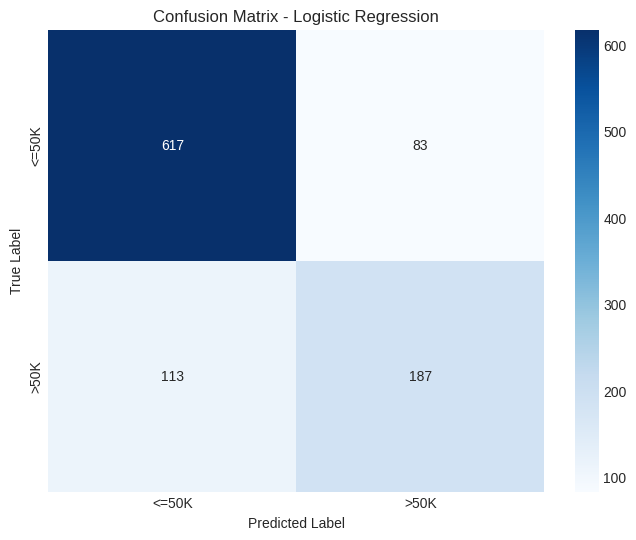


=== Training Decision Tree ===
Accuracy: 0.8050

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       700
           1       0.68      0.67      0.67       300

    accuracy                           0.81      1000
   macro avg       0.77      0.77      0.77      1000
weighted avg       0.80      0.81      0.80      1000


Confusion Matrix:
[[605  95]
 [100 200]]


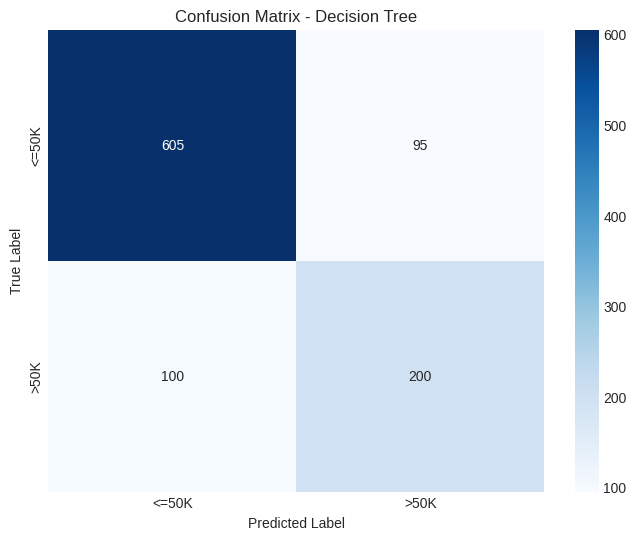

In [20]:
# --- Model Training and Evaluation ---
def train_and_evaluate_models(X, y, preprocessor):
    """
    Train and evaluate multiple models

    Parameters:
    -----------
    X : pd.DataFrame
        Features
    y : pd.Series
        Target variable
    preprocessor : ColumnTransformer
        Preprocessor for the data

    Returns:
    --------
    models : dict
        Dictionary of trained models
    results : dict
        Dictionary of model results
    """
    # Check for class distribution before splitting
    print("Target class distribution before splitting:")
    print(pd.Series(y).value_counts())

    if len(pd.Series(y).unique()) < 2:
        raise ValueError("Dataset contains only one class. Please ensure the dataset contains both income classes.")

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )

    # Check class distribution after splitting
    print("\nTraining set class distribution:")
    print(pd.Series(y_train).value_counts())
    print("\nTest set class distribution:")
    print(pd.Series(y_test).value_counts())

    # Create model pipelines
    models = {
        'Logistic Regression': Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))
        ]),
        'Decision Tree': Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=5))
        ])
    }

    # Train and evaluate models
    results = {}
    for name, model in models.items():
        print(f"\n=== Training {name} ===")
        model.fit(X_train, y_train)

        # Evaluate on test set
        y_pred = model.predict(X_test)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)

        # Store results
        results[name] = {
            'accuracy': accuracy,
            'classification_report': report,
            'confusion_matrix': conf_matrix
        }

        # Display results
        print(f"Accuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(report)
        print("\nConfusion Matrix:")
        print(conf_matrix)

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                    xticklabels=['<=50K', '>50K'],
                    yticklabels=['<=50K', '>50K'])
        plt.title(f'Confusion Matrix - {name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.savefig(f'{name.lower().replace(" ", "_")}_confusion_matrix.png',
                   dpi=300, bbox_inches='tight')
        plt.show()

    return models, results

# Run the full pipeline
if df_train is not None:
    X, y, preprocessor = preprocess_data(df_train)
    models, results = train_and_evaluate_models(X, y, preprocessor)

# --- Feature Importance Analysis ---

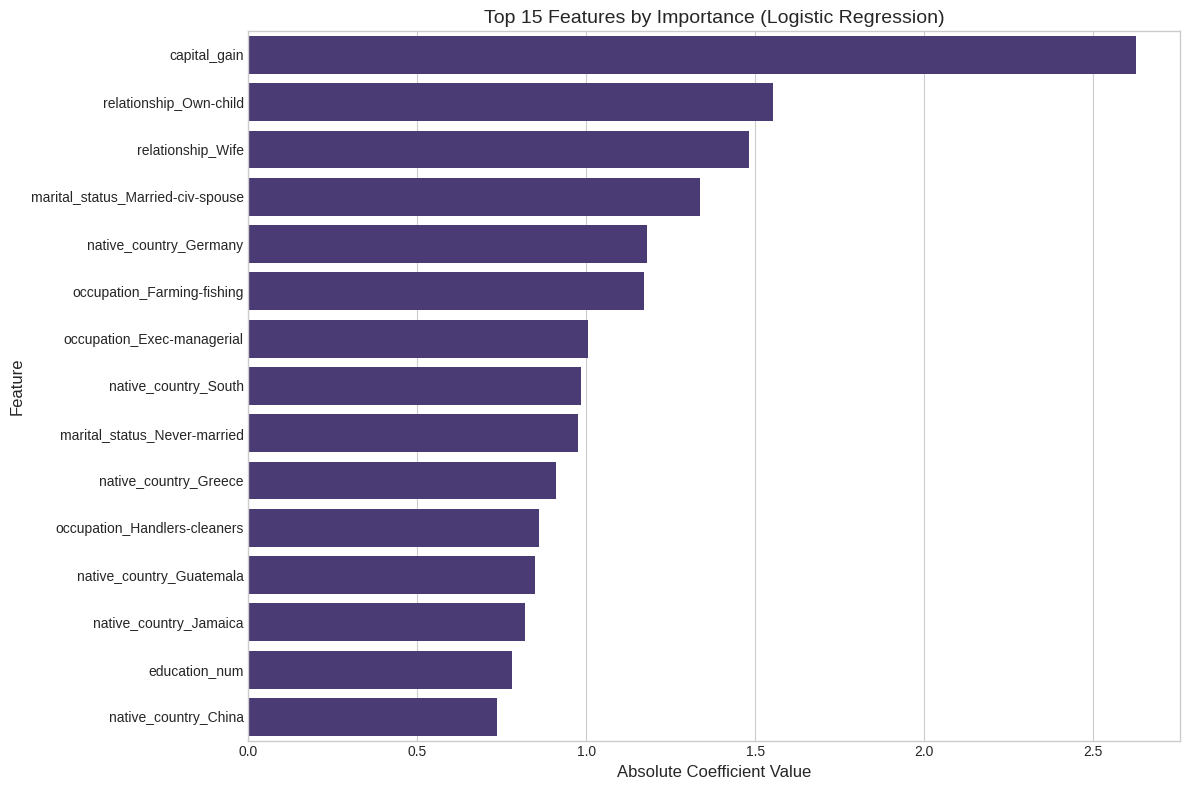

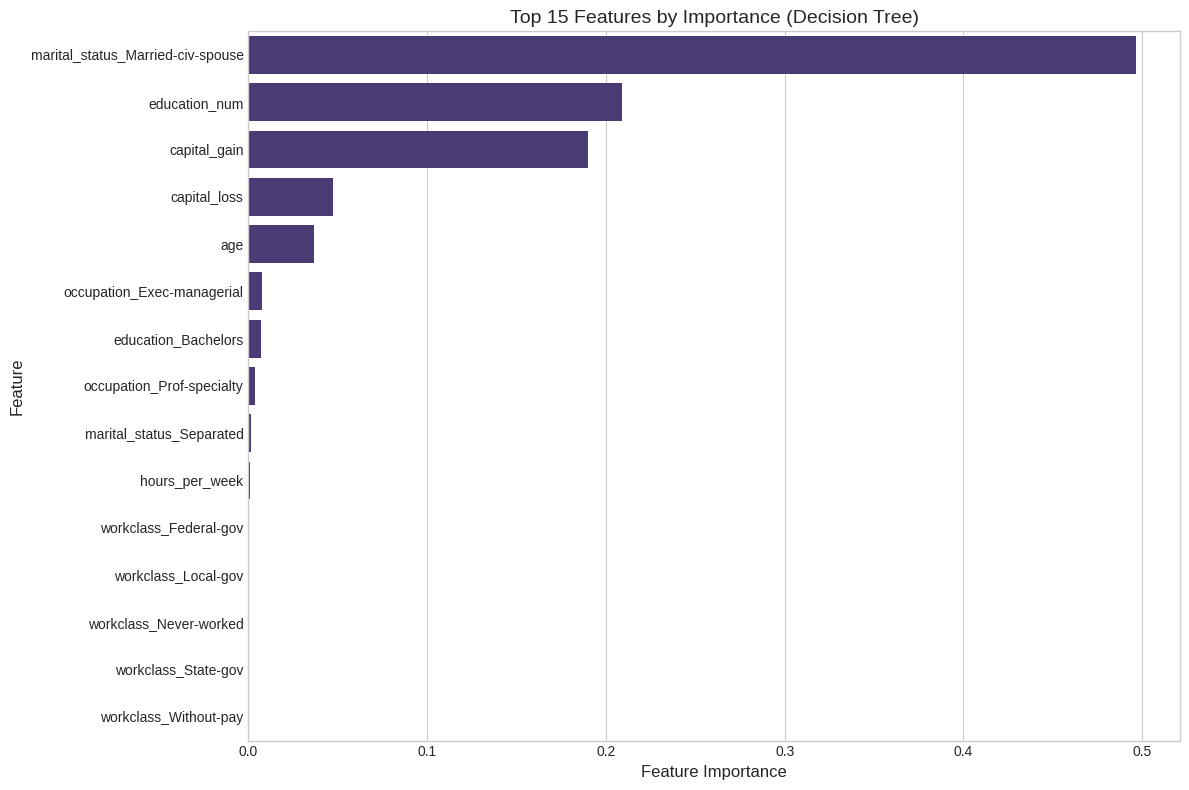

In [21]:
# --- Feature Importance Analysis ---
def analyze_feature_importance(models, X, preprocessor):
    """
    Analyze feature importance for the trained models

    Parameters:
    -----------
    models : dict
        Dictionary of trained models
    X : pd.DataFrame
        Features dataframe
    preprocessor : ColumnTransformer
        Data preprocessor
    """
    # Extract feature names after one-hot encoding
    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

    # Fit the preprocessor to get feature names
    preprocessor.fit(X)

    # Get one-hot encoder feature names
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    categorical_features = ohe.get_feature_names_out(categorical_cols)

    # Combine all feature names
    feature_names = np.concatenate([numerical_cols, categorical_features])

    # Extract and plot feature importance for Logistic Regression
    if 'Logistic Regression' in models:
        # Get coefficients
        log_reg = models['Logistic Regression'].named_steps['classifier']
        coefficients = log_reg.coef_[0]

        # Create DataFrame for visualization
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': np.abs(coefficients)
        })

        # Sort by importance
        feature_importance = feature_importance.sort_values('Importance', ascending=False)

        # Plot top 15 features
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
        plt.title('Top 15 Features by Importance (Logistic Regression)', fontsize=14)
        plt.xlabel('Absolute Coefficient Value', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.tight_layout()
        plt.savefig('logistic_regression_feature_importance.png', dpi=300, bbox_inches='tight')
        plt.show()

    # Extract and plot feature importance for Decision Tree
    if 'Decision Tree' in models:
        # Get feature importance
        dt = models['Decision Tree'].named_steps['classifier']
        importances = dt.feature_importances_

        # Create DataFrame for visualization
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        })

        # Sort by importance
        feature_importance = feature_importance.sort_values('Importance', ascending=False)

        # Plot top 15 features
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
        plt.title('Top 15 Features by Importance (Decision Tree)', fontsize=14)
        plt.xlabel('Feature Importance', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.tight_layout()
        plt.savefig('decision_tree_feature_importance.png', dpi=300, bbox_inches='tight')
        plt.show()

# Analyze feature importance
if df_train is not None and 'models' in locals():
    analyze_feature_importance(models, X, preprocessor)

# --- GitHub Integration ---

In [22]:
# This section contains instructions for pushing to GitHub

"""
# GitHub Integration Instructions

To push this notebook to GitHub:

1. Save this notebook in Colab

2. Connect Colab to GitHub:
   - Click on File > Save a copy in GitHub
   - Select or create a repository
   - Add appropriate commit message

3. Alternative: Manual Push
   ```bash
   # Clone your repository (if not already done)
   !git clone https://github.com/your-username/your-repo.git

   # Copy the notebook to the repository directory
   !cp "Income_Prediction_UCI_Adult_Dataset.ipynb" "your-repo/"

   # Navigate to the repository directory
   %cd your-repo

   # Add the notebook to tracking
   !git add "Income_Prediction_UCI_Adult_Dataset.ipynb"

   # Commit the changes
   !git commit -m "Add initial income prediction exploration notebook"

   # Push to GitHub
   !git push
   ```

4. For future updates, use GitHub Desktop or git commands from the terminal
"""

"""
# Next Steps

1. Scale to full dataset
   - Load and process the entire UCI Adult dataset
   - Compare model performance between sample and full dataset

2. Feature engineering
   - Create new features from existing ones (e.g., education-to-age ratio)
   - Explore interaction terms between features

3. Advanced modeling
   - Implement gradient boosting models (XGBoost, LightGBM)
   - Use Random Forest for handling complex interactions
   - Apply hyperparameter tuning

4. Model explainability
   - Implement SHAP values for model interpretation
   - Create partial dependence plots

5. Production pipeline
   - Create a scalable preprocessing and inference pipeline
   - Set up model monitoring
   - Implement cross-validation strategy
"""

print("Notebook execution completed!")

Notebook execution completed!
